In [43]:
## Introduction
"""
This example shows how to do image classification from scratch, starting from JPEG
image files on disk, without leveraging pre-trained weights or a pre-made Keras
Application model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary
 classification dataset.

We use the `image_dataset_from_directory` utility to generate the datasets, and
we use Keras image preprocessing layers for image standardization and data augmentation.
"""

"""
## Setup
"""
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [44]:
"""
## Generate a `Dataset`
"""

image_size = (120, 160)
batch_size = 10
class_names = ["cross_leg", "cross_one", "hunch", "lie", "straight"]

train_ds = tf.keras.utils.image_dataset_from_directory(
    "../dataset/train_data",
    validation_split=0.2,
    seed = 32,
    subset = "training",
    image_size = image_size,
    batch_size = batch_size,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "../dataset/train_data",
    validation_split=0.2,
    seed = 32,
    subset = "validation",
    image_size = image_size,
    batch_size = batch_size,
)

Found 278 files belonging to 5 classes.
Using 223 files for training.
Found 278 files belonging to 5 classes.
Using 55 files for validation.


In [45]:
"""
## Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to the
training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
overfitting.
"""

data_augmentation = keras.Sequential(
    [   
        layers.Rescaling(1./255),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)


In [46]:
"""
## Standardizing the data

Our image are already in a standard size (180x180), as they are being yielded as
contiguous `float32` batches by our dataset. However, their RGB channel values are in
the `[0, 255]` range. This is not ideal for a neural network;
in general you should seek to make your input values small. Here, we will
standardize values to be in the `[0, 1]` by using a `Rescaling` layer at the start of
our model.
"""

"""
## Two options to preprocess the data

There are two ways you could be using the `data_augmentation` preprocessor:

**Option 1: Make it part of the model**, like this:

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
...  # Rest of the model
```

With this option, your data augmentation will happen *on device*, synchronously
with the rest of the model execution, meaning that it will benefit from GPU
acceleration.

Note that data augmentation is inactive at test time, so the input samples will only be
augmented during `fit()`, not when calling `evaluate()` or `predict()`.

If you're training on GPU, this may be a good option.

**Option 2: apply it to the dataset**, so as to obtain a dataset that yields batches of
augmented images, like this:

```python
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))
```

With this option, your data augmentation will happen **on CPU**, asynchronously, and will
be buffered before going into the model.

If you're training on CPU, this is the better option, since it makes data augmentation
asynchronous and non-blocking.

In our case, we'll go with the second option. If you're not sure
which one to pick, this second option (asynchronous preprocessing) is always a solid choice.
"""

"""
## Configure the dataset for performance

Let's apply data augmentation to our training dataset,
and let's make sure to use buffered prefetching so we can yield data from disk without
having I/O becoming blocking:
"""

# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [47]:
"""
## Build a model

We'll build a small version of the Xception network. We haven't particularly tried to
optimize the architecture; if you want to do a systematic search for the best model
configuration, consider using
[KerasTuner](https://github.com/keras-team/keras-tuner).

Note that:

- We start the model with the `data_augmentation` preprocessor, followed by a
 `Rescaling` layer.
- We include a `Dropout` layer before the final classification layer.
"""


def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Conv2D(128, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes = 5)
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 120, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 60, 80, 128)  3584        ['input_3[0][0]']                
                                                                                                  
 batch_normalization_16 (BatchN  (None, 60, 80, 128)  512        ['conv2d_8[0][0]']               
 ormalization)                                                                                    
                                                                                            

In [37]:
"""
## Train the model
"""

epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_best.keras", save_best_only=True),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/2
23/23 [==============================] - 60s 2s/step - loss: 1.2370 - accuracy: 0.5426 - val_loss: 34.9840 - val_accuracy: 0.2727
Epoch 2/2
23/23 [==============================] - 53s 2s/step - loss: 0.8702 - accuracy: 0.7130 - val_loss: 75.0702 - val_accuracy: 0.2727


In [38]:
#import header for confusion matrix
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import itertools
from matplotlib import pyplot as plt

In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """Plots the confusion matrix."""
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=55)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

Found 125 images belonging to 5 classes.
13/13 [==============================] - 13s 1s/step
Confusion matrix, without normalization
              precision    recall  f1-score   support

  cross_legs       0.00      0.00      0.00        20
   cross_one       0.00      0.00      0.00        17
       hunch       0.00      0.00      0.00        29
         lie       0.00      0.00      0.00        25
    straight       0.27      1.00      0.43        34

    accuracy                           0.27       125
   macro avg       0.05      0.20      0.09       125
weighted avg       0.07      0.27      0.12       125



C:\Users\bosyu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bosyu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bosyu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344

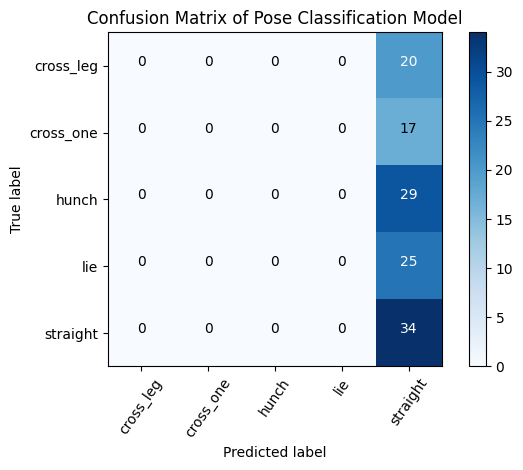

In [41]:
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    "../dataset/test_data", # Put your path here
     target_size=(image_size[0], image_size[1]),
    batch_size=batch_size,
    shuffle=False)
test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model.predict(test_data_generator)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys()) 

cm = confusion_matrix(true_classes, predicted_classes)
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

In [42]:
"""
We get to >90% validation accuracy after training for 25 epochs on the full dataset
(in practice, you can train for 50+ epochs before validation performance starts degrading).
"""

"""
## Run inference on new data

Note that data augmentation and dropout are inactive at inference time.
"""
img = keras.utils.load_img(r"../dataset/train_data/hunch/IMG_7185.jpg", target_size = image_size)
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(predictions)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

1/1 [==============================] - 0s 224ms/step
[[0.0000000e+00 0.0000000e+00 1.3953469e-34 5.7557500e-28 1.0000000e+00]]


TypeError: only size-1 arrays can be converted to Python scalars